### This notebook serves as a comprehensive guide to understanding and utilising the SAML-D dataset, specifically designed for enhancing anti-money laundering (AML) strategies. Initially, it delves into exploratory data analysis, providing a thorough examination of the dataset's characteristics. Following the EDA, there is a preprocessing phase, ensuring the data is optimised for modeling. Then an experiment employing the XGBoost classifier is conducted, a powerful machine learning tool well-known for its efficiency and effectiveness. This experiment is not merely a demonstration of predictive modeling but a practical application aimed at detecting potential money laundering activities, showcasing the dataset's utility in developing robust transaction monitoinrg solutions in AML.








In [2]:
pip install seaborn

DEPRECATION: Loading egg at c:\python312\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from PIL import Image
from scipy.stats import skew
from matplotlib.transforms import Bbox

Matplotlib is building the font cache; this may take a moment.


In [4]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv(r"C:\Users\91998\Downloads\SAML-D.csv")

In [7]:
df.shape

(9504852, 12)

In [8]:
df.head()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
0,10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits
1,10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0,Normal_Fan_Out
2,10:35:20,2022-10-07,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out
3,10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In
4,10:35:21,2022-10-07,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits


In [9]:
df.tail()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
9504847,10:57:01,2023-08-23,2453933570,519744068,2247.25,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Small_Fan_Out
9504848,10:57:06,2023-08-23,9805510177,5416607878,927.18,UK pounds,UK pounds,UK,UK,Debit card,0,Normal_Small_Fan_Out
9504849,10:57:06,2023-08-23,7282330957,2995527149,1455.14,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Small_Fan_Out
9504850,10:57:11,2023-08-23,940337377,4812815165,25995.70,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In
9504851,10:57:12,2023-08-23,105185176,6824994831,9586.08,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_Out


### Exploratory Data Analysis 

In [10]:
# number of transactions per payment type
transactions_per_payment_type = df['Payment_type'].value_counts()

# number of laundering transactions per payment type
laundering_transactions_per_payment_type = df[df['Is_laundering'] == 1].groupby('Payment_type').size()

transactions_per_payment_type, laundering_transactions_per_payment_type

(Payment_type
 Credit card        2012909
 Debit card         2012103
 Cheque             2011419
 ACH                2008807
 Cross-border        933931
 Cash Withdrawal     300477
 Cash Deposit        225206
 Name: count, dtype: int64,
 Payment_type
 ACH                1159
 Cash Deposit       1405
 Cash Withdrawal    1334
 Cheque             1087
 Credit card        1136
 Cross-border       2628
 Debit card         1124
 dtype: int64)

In [11]:
df.describe()

,Sender_account,Receiver_account,Amount,Is_laundering
count,9.504852e+06,9.504852e+06,9.504852e+06,9.504852e+06
mean,5.006619e+09,5.006006e+09,8.762968e+03,1.038733e-03
std,2.885814e+09,2.884763e+09,2.561495e+04,3.221263e-02
min,9.018000e+03,9.018000e+03,3.730000e+00,0.000000e+00
25%,2.513133e+09,2.513219e+09,2.143688e+03,0.000000e+00
50%,5.001017e+09,5.002572e+09,6.113720e+03,0.000000e+00
75%,7.505051e+09,7.502397e+09,1.045846e+04,0.000000e+00
max,9.999987e+09,9.999971e+09,1.261850e+07,1.000000e+00


In [12]:
laundering_stats = df[df['Is_laundering'] == 1]['Amount'].agg(['max', 'mean', 'min'])

normal_stats = df[df['Is_laundering'] == 0]['Amount'].agg(['max', 'mean', 'min'])

print("Laundering Transactions Stats:\n", laundering_stats)
print("\nNormal Transactions Stats:\n", normal_stats)

Laundering Transactions Stats:
 max     1.261850e+07
mean    4.058767e+04
min     1.582000e+01
Name: Amount, dtype: float64

Normal Transactions Stats:
 max     999962.190000
mean      8729.875874
min          3.730000
Name: Amount, dtype: float64


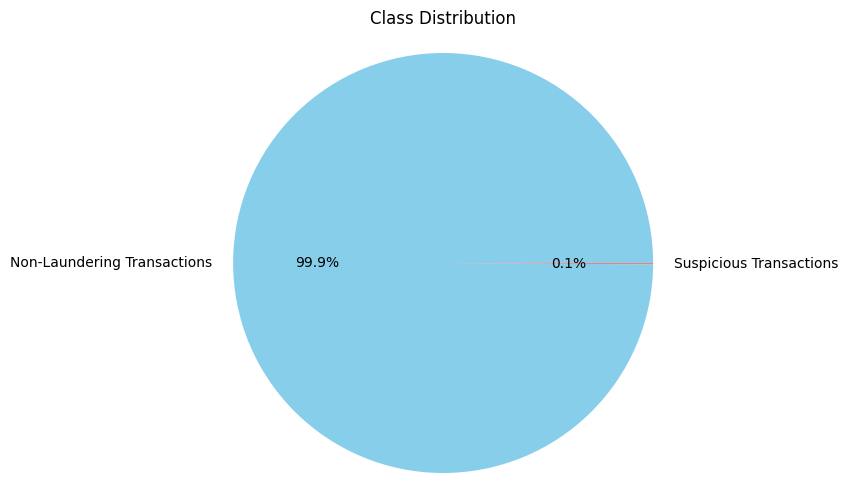

In [13]:
class_distribution = df['Is_laundering'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(class_distribution, labels=['Non-Laundering Transactions', 'Suspicious Transactions'], autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])

plt.title('Class Distribution')
plt.axis('equal')

plt.show()

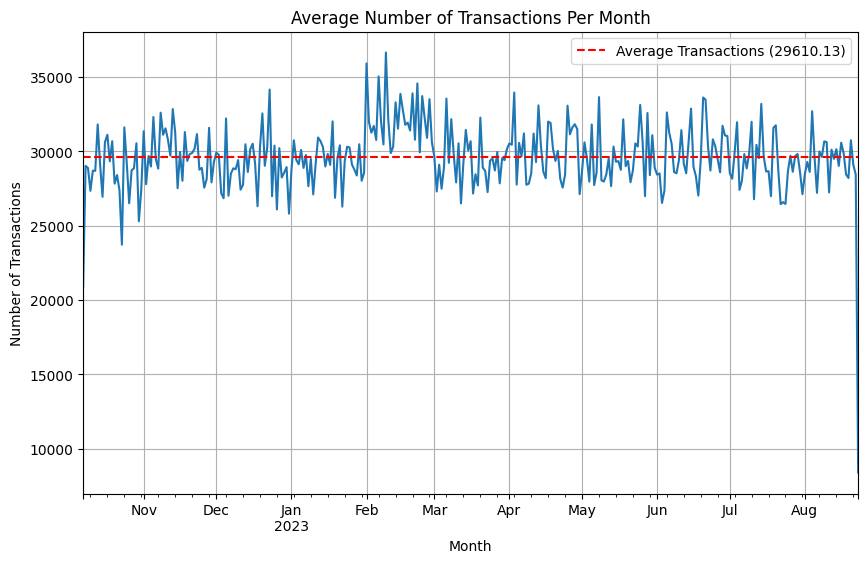

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
monthly_transactions = df.groupby(df['Date'].dt.to_period('D')).size()

# number of transactions per month
average_monthly_transactions = monthly_transactions.mean()

plt.figure(figsize=(10, 6))
monthly_transactions.plot(kind='line')
plt.axhline(y=average_monthly_transactions, color='r', linestyle='--', label=f'Average Transactions ({average_monthly_transactions:.2f})')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.title('Average Number of Transactions Per Month')
plt.legend()
plt.grid(True)
plt.show()

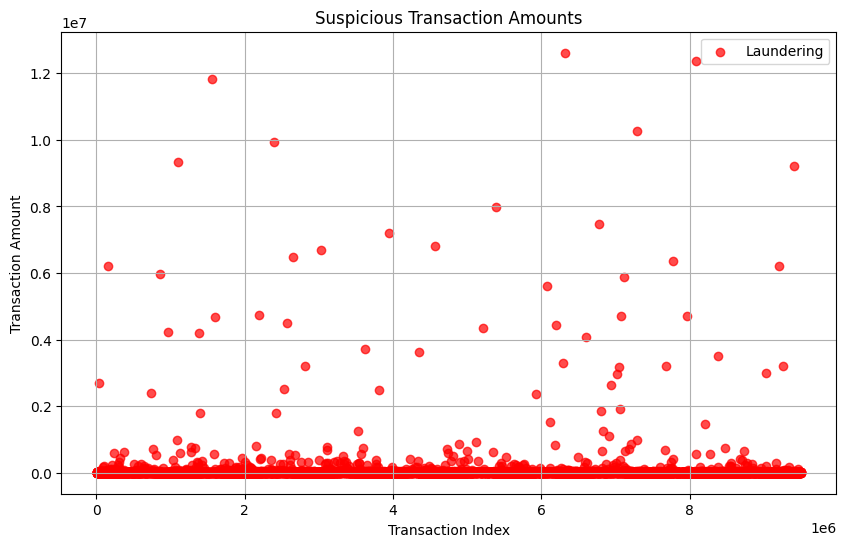

In [15]:
# Separate the data
laundering_data = df[df['Is_laundering'] == 1]
non_laundering_data = df[df['Is_laundering'] == 0]

plt.figure(figsize=(10, 6))
plt.scatter(laundering_data.index, laundering_data['Amount'], color='red', label='Laundering', alpha=0.7)

plt.title('Suspicious Transaction Amounts')
plt.xlabel('Transaction Index')
plt.ylabel('Transaction Amount')
plt.legend()
plt.grid(True)
plt.show()

Text(0.5, 0, 'Number of Alerts')

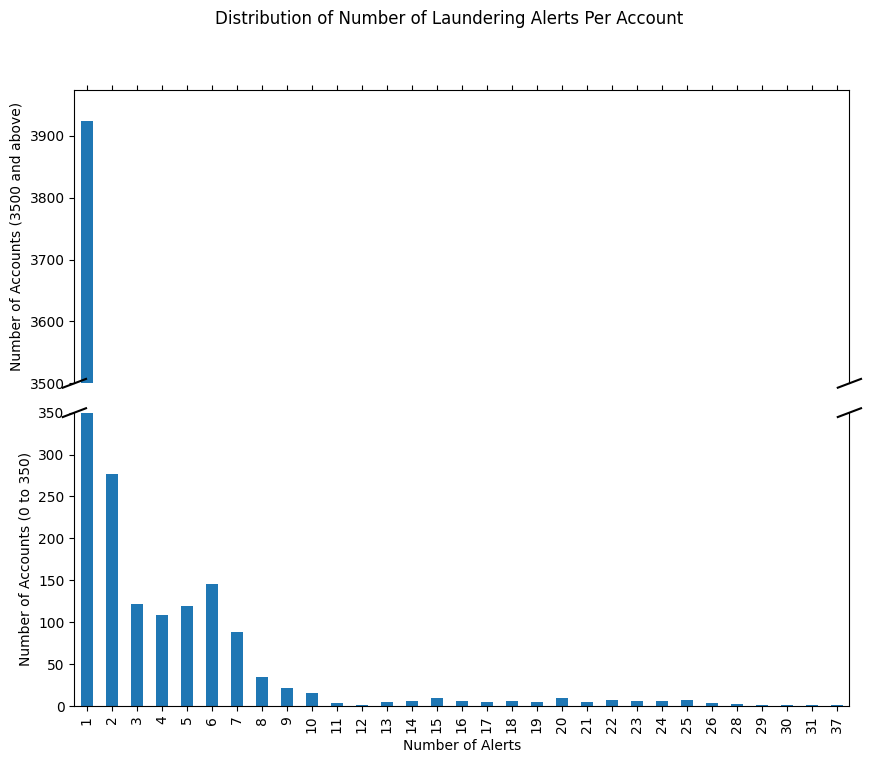

In [16]:
laundering_df = df[df['Is_laundering'] == 1]

account_alert_counts = laundering_df.groupby('Sender_account').size()
alert_distribution = account_alert_counts.value_counts()
alert_distribution = alert_distribution.sort_index()

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
fig.subplots_adjust(hspace=0.1)

alert_distribution.plot(kind='bar', ax=ax1)
alert_distribution.plot(kind='bar', ax=ax2)

fig.suptitle('Distribution of Number of Laundering Alerts Per Account')

ax1.set_ylim(3500, alert_distribution.max()+50)
ax2.set_ylim(0, 350)

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)
ax2.xaxis.tick_bottom()

d = .015  # diagonal lines size
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

ax2.set_ylabel('Number of Accounts (0 to 350)')
ax1.set_ylabel('Number of Accounts (3500 and above)')
ax2.set_xlabel('Number of Alerts')

Original Skewness: 102.16408577285024
Log-Transformed Skewness: -1.0103052224946008


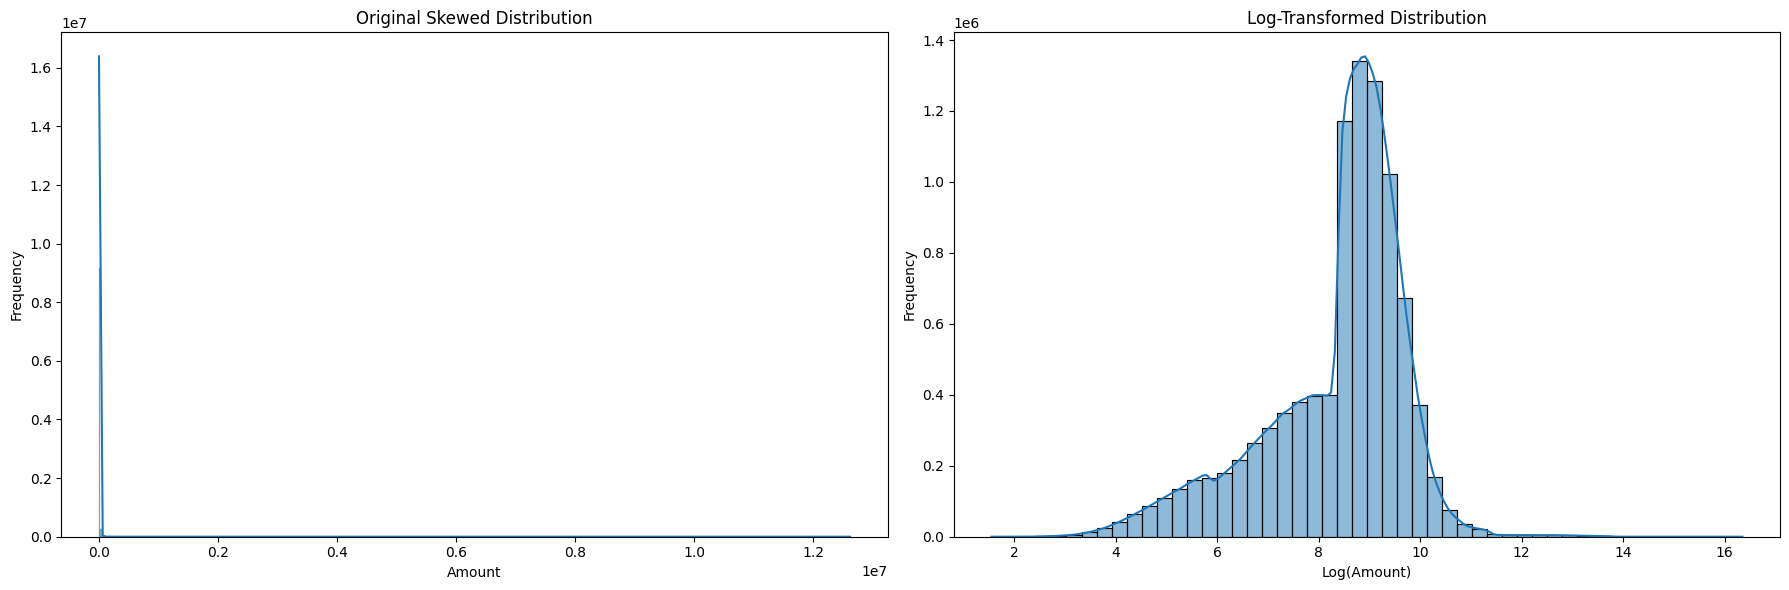

In [17]:
skewed_data = df['Amount']

original_skewness = skew(skewed_data)
print(f"Original Skewness: {original_skewness}")

# Apply a log transformation
log_transformed_data = np.log1p(skewed_data)
# skewness after log transformation
transformed_skewness = skew(log_transformed_data)
print(f"Log-Transformed Skewness: {transformed_skewness}")

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(skewed_data, bins=500, kde=True, ax=ax[0])
ax[0].set_title('Original Skewed Distribution')
ax[0].set_xlabel('Amount')
ax[0].set_ylabel('Frequency')

sns.histplot(log_transformed_data, bins=50, kde=True, ax=ax[1])
ax[1].set_title('Log-Transformed Distribution')
ax[1].set_xlabel('Log(Amount)')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [18]:
total_amount_pivot = pd.pivot_table(df, index=["Payment_type"], values='Amount', aggfunc=np.sum)
laundering_count_pivot = df[df['Is_laundering'] == 1].groupby('Payment_type').size().to_frame('Laundering_Count')
normal_count_pivot = df[df['Is_laundering'] == 0].groupby('Payment_type').size().to_frame('Normal_Count')

combined_pivot = total_amount_pivot.join([laundering_count_pivot, normal_count_pivot], how='outer')
combined_pivot = combined_pivot.fillna(0)

cm = sns.light_palette("blue", as_cmap=True)
styled_combined_pivot = combined_pivot.style.background_gradient(cmap=cm)

styled_combined_pivot

C:\Users\91998\AppData\Local\Temp\ipykernel_25792\1828936050.py:1: FutureWarning: The provided callable <function sum at 0x0000016355C5D9E0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  total_amount_pivot = pd.pivot_table(df, index=["Payment_type"], values='Amount', aggfunc=np.sum)


,Amount,Laundering_Count,Normal_Count
Payment_type,,,
ACH,18272052011.854218,1159,2007648
Cash Deposit,485809045.640000,1405,223801
Cash Withdrawal,46118125.580000,1334,299143
Cheque,18328875956.816402,1087,2010332
Credit card,18308924931.183823,1136,2011773
Cross-border,9476591292.695444,2628,931303
Debit card,18372338763.838520,1124,2010979


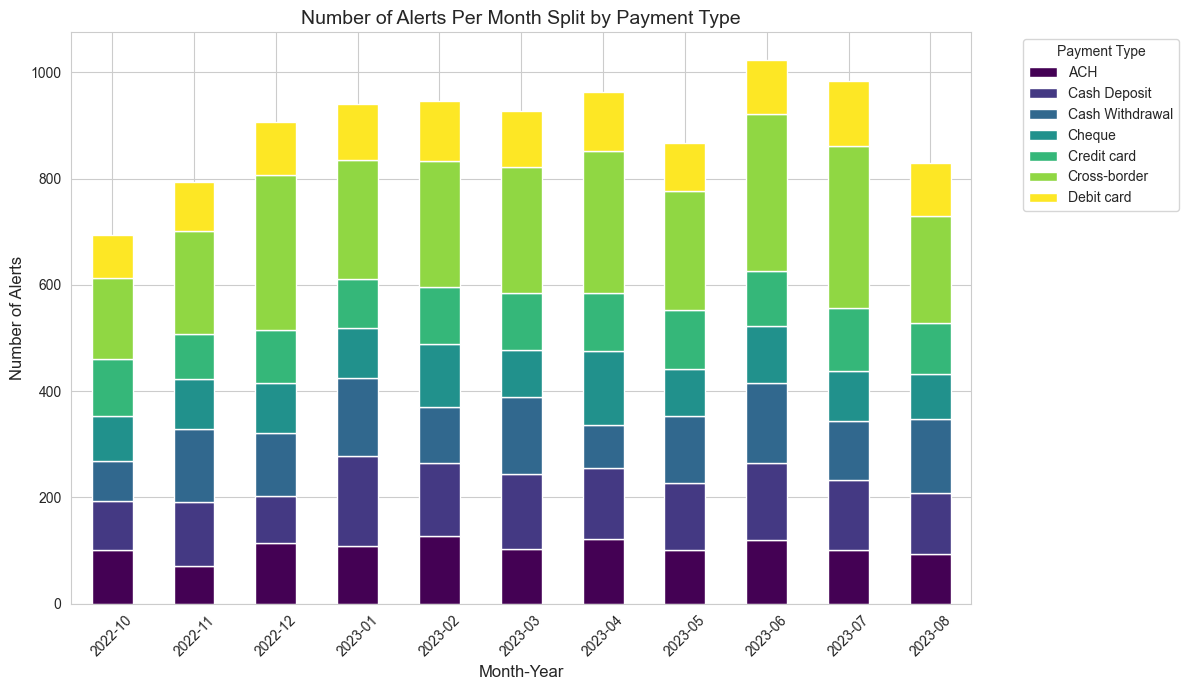

In [19]:
df['Date'] = pd.to_datetime(df['Date'])
grouped_data = df.groupby(['Date', 'Payment_type']).agg({'Is_laundering': 'sum'}).reset_index()
grouped_data['Month_Year'] = grouped_data['Date'].dt.to_period('M')
monthly_alerts = grouped_data.groupby(['Month_Year', 'Payment_type']).agg({'Is_laundering': 'sum'}).reset_index()

pivot_data = monthly_alerts.pivot(index='Month_Year', columns='Payment_type', values='Is_laundering')

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 7))
pivot_data.plot(kind='bar', ax=ax, stacked=True, colormap='viridis')
pivot_data = monthly_alerts.pivot(index='Month_Year', columns='Payment_type', values='Is_laundering')

plt.title('Number of Alerts Per Month Split by Payment Type', fontsize=14)
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('Number of Alerts', fontsize=12)
plt.xticks(rotation=45)

plt.legend(title='Payment Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

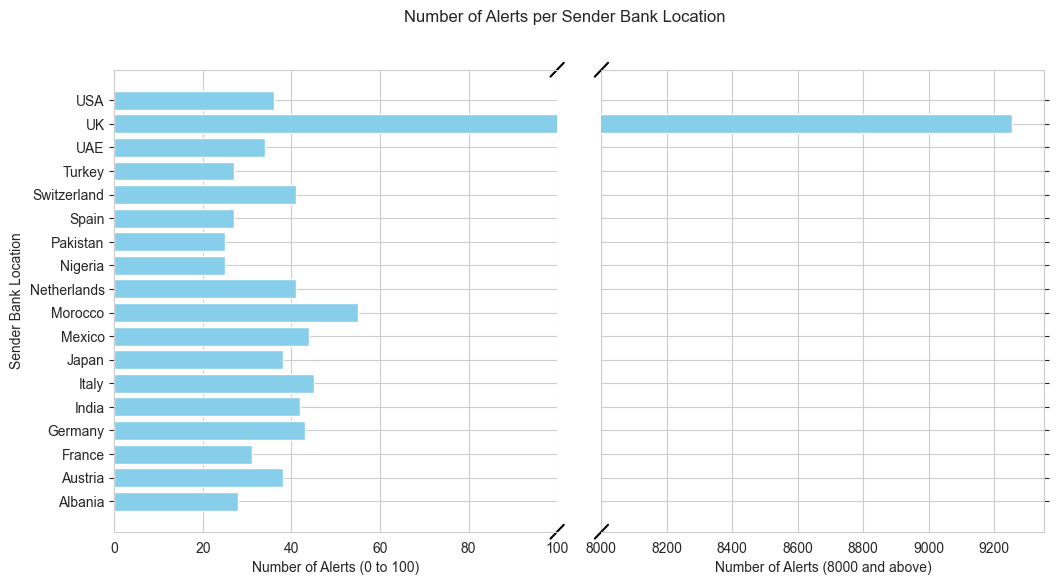

In [20]:
alerts_per_location = df.groupby('Sender_bank_location')['Is_laundering'].sum().reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
fig.subplots_adjust(wspace=0.1)

ax1.barh(alerts_per_location['Sender_bank_location'], alerts_per_location['Is_laundering'], color='skyblue')
ax2.barh(alerts_per_location['Sender_bank_location'], alerts_per_location['Is_laundering'], color='skyblue')

ax1.set_xlim(0, 100)  # Set the left subplot values
ax2.set_xlim(8000, max(alerts_per_location['Is_laundering']) + 100)  # Set the right subplot values

fig.suptitle('Number of Alerts per Sender Bank Location')

ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax2.yaxis.tick_right()
ax2.set_yticks([])

d = .015  # Size of diagonal lines
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (-d, +d), **kwargs)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)

ax1.set_xlabel('Number of Alerts (0 to 100)')
ax2.set_xlabel('Number of Alerts (8000 and above)')
ax1.set_ylabel('Sender Bank Location')

ax1.set_yticks(range(len(alerts_per_location['Sender_bank_location'])))
ax1.set_yticklabels(alerts_per_location['Sender_bank_location'])

plt.show()

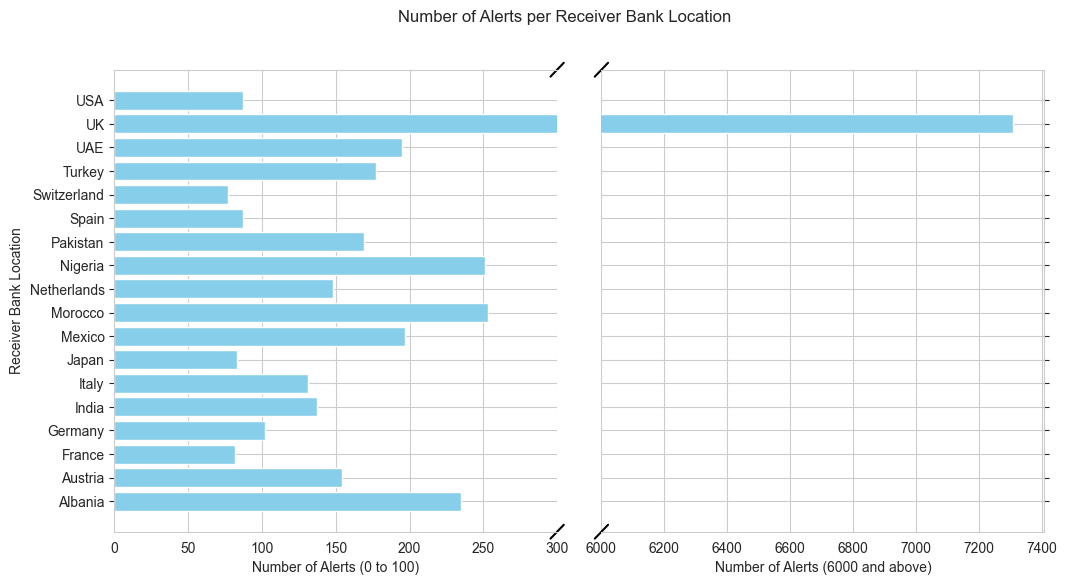

In [21]:
alerts_per_location = df.groupby('Receiver_bank_location')['Is_laundering'].sum().reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
fig.subplots_adjust(wspace=0.1)  # Adjust the spacing between subplots

ax1.barh(alerts_per_location['Receiver_bank_location'], alerts_per_location['Is_laundering'], color='skyblue')
ax2.barh(alerts_per_location['Receiver_bank_location'], alerts_per_location['Is_laundering'], color='skyblue')

ax1.set_xlim(0, 300)  # Set the left subplot values
ax2.set_xlim(6000, max(alerts_per_location['Is_laundering']) + 100)  # Set the right subplot values

fig.suptitle('Number of Alerts per Receiver Bank Location')

ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax2.yaxis.tick_right()
ax2.set_yticks([])

d = .015  # Size of diagonal lines
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (-d, +d), **kwargs)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)

ax1.set_xlabel('Number of Alerts (0 to 100)')
ax2.set_xlabel('Number of Alerts (6000 and above)')
ax1.set_ylabel('Receiver Bank Location')

ax1.set_yticks(range(len(alerts_per_location['Receiver_bank_location'])))
ax1.set_yticklabels(alerts_per_location['Receiver_bank_location'])

plt.show()

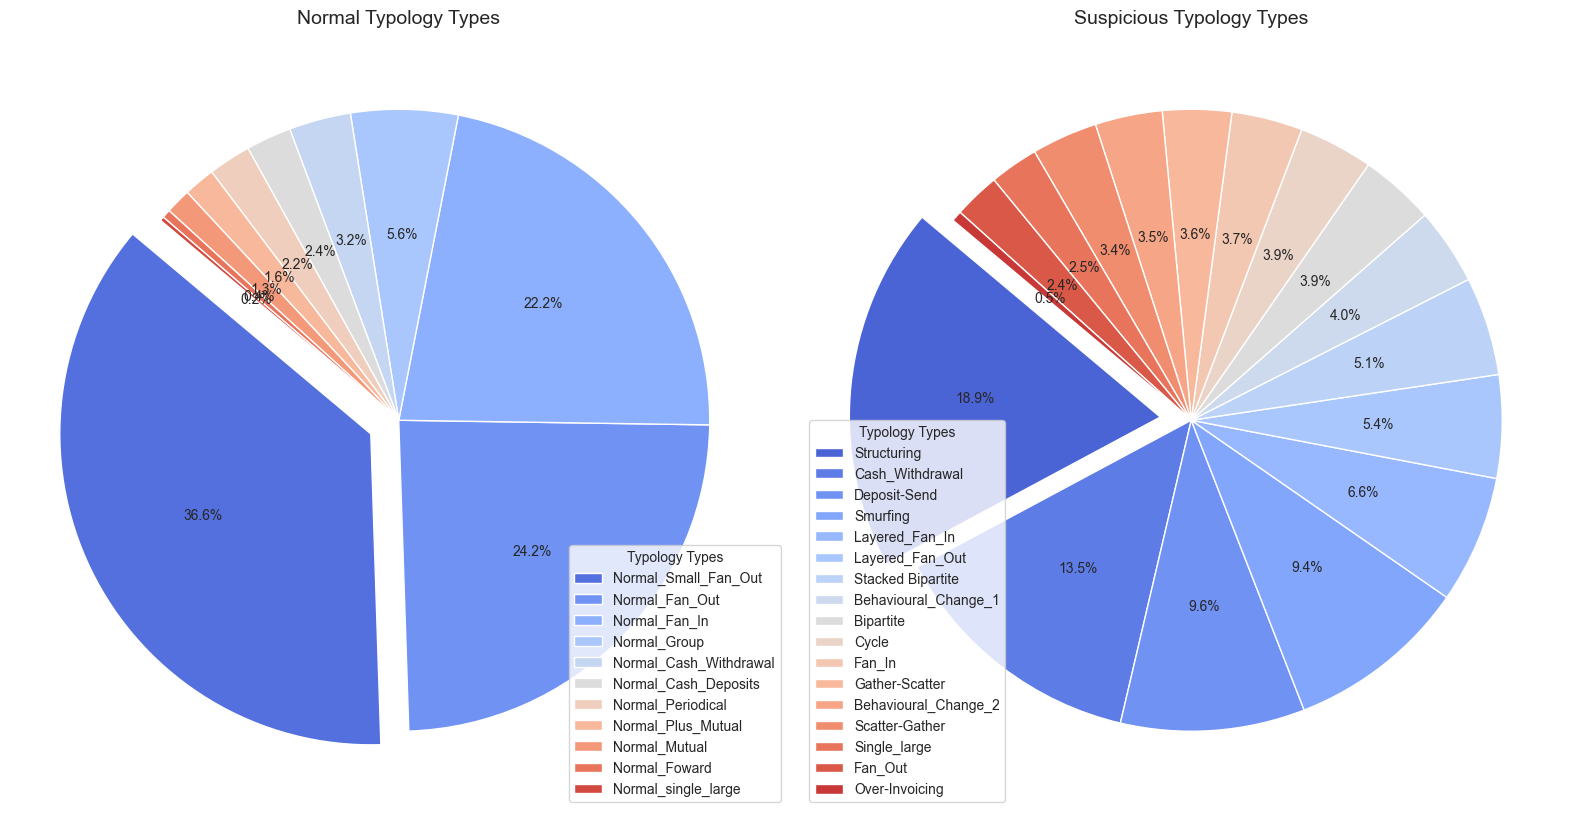

In [22]:
normal_data = df[df['Is_laundering'] == 0]['Laundering_type'].value_counts()
laundering_data = df[df['Is_laundering'] == 1]['Laundering_type'].value_counts()

# palette_normal = sns.color_palette("husl", len(normal_data))
palette_normal = sns.color_palette("coolwarm", len(normal_data))
palette_laundering = sns.color_palette("coolwarm", len(laundering_data))

fig, axs = plt.subplots(1, 2, figsize=(16, 10))

explode_normal = [0.1] + [0] * (len(normal_data) - 1)
explode_laundering = [0.1] + [0] * (len(laundering_data) - 1)

patches, texts, autotexts = axs[0].pie(normal_data, explode=explode_normal, autopct='%1.1f%%', colors=palette_normal, startangle=140)
axs[0].set_title('Normal Typology Types', fontsize=14)
axs[0].legend(patches, normal_data.index, loc='best', title="Typology Types", fontsize=10)

patches, texts, autotexts = axs[1].pie(laundering_data, explode=explode_laundering, autopct='%1.1f%%', colors=palette_laundering, startangle=140)
axs[1].set_title('Suspicious Typology Types', fontsize=14)
axs[1].legend(patches, laundering_data.index, loc='best', title="Typology Types", fontsize=10)

for text in texts + autotexts:
  text.set_fontsize(10)

plt.tight_layout()
plt.show()

In [24]:
df = pd.read_csv(r"C:\Users\91998\Downloads\SAML-D.csv")

## Pre-Processing the Data

In [25]:
df['Hour'] = pd.to_datetime(df['Time']).dt.hour

df['Date_Year'] = pd.to_datetime(df['Date']).dt.year
df['Date_Month'] = pd.to_datetime(df['Date']).dt.month
df['Date_Day'] = pd.to_datetime(df['Date']).dt.day

df.drop(columns=['Laundering_type'], inplace=True)
df.drop(columns=['Time', 'Date'], inplace=True)


C:\Users\91998\AppData\Local\Temp\ipykernel_25792\2383917675.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Hour'] = pd.to_datetime(df['Time']).dt.hour


In [26]:
skewed_data = df['Amount']
original_skewness = skew(skewed_data)
print(f"Original Skewness: {original_skewness}")

log_transformed_data = np.log1p(skewed_data)
transformed_skewness = skew(log_transformed_data)
print(f"Log-Transformed Skewness: {transformed_skewness}")

df['Amount'] = log_transformed_data

Original Skewness: 102.16408577285024
Log-Transformed Skewness: -1.0103052224946008


In [27]:
categorical_cols = ['Sender_account', 'Receiver_account', 'Payment_currency', 'Received_currency',
                   'Sender_bank_location', 'Receiver_bank_location', 'Payment_type',
                   'Date_Year', 'Date_Month', 'Date_Day']

for col in categorical_cols:
    encoder = preprocessing.LabelEncoder()
    df[col] = encoder.fit_transform(df[col])

numerical_cols = ['Hour', 'Amount']

scaler = preprocessing.StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

df.head()

,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Hour,Date_Year,Date_Month,Date_Day
0,255277,180462,-0.756957,10,10,16,16,1,0,-0.732897,0,8,6
1,43554,548141,0.253092,10,1,16,15,5,0,-0.732897,0,8,6
2,8553,287765,0.871335,10,10,16,16,3,0,-0.732897,0,8,6
3,157249,626370,0.738639,10,10,16,16,0,0,-0.732897,0,8,6
4,281324,248338,-2.561195,10,10,16,16,1,0,-0.732897,0,8,6


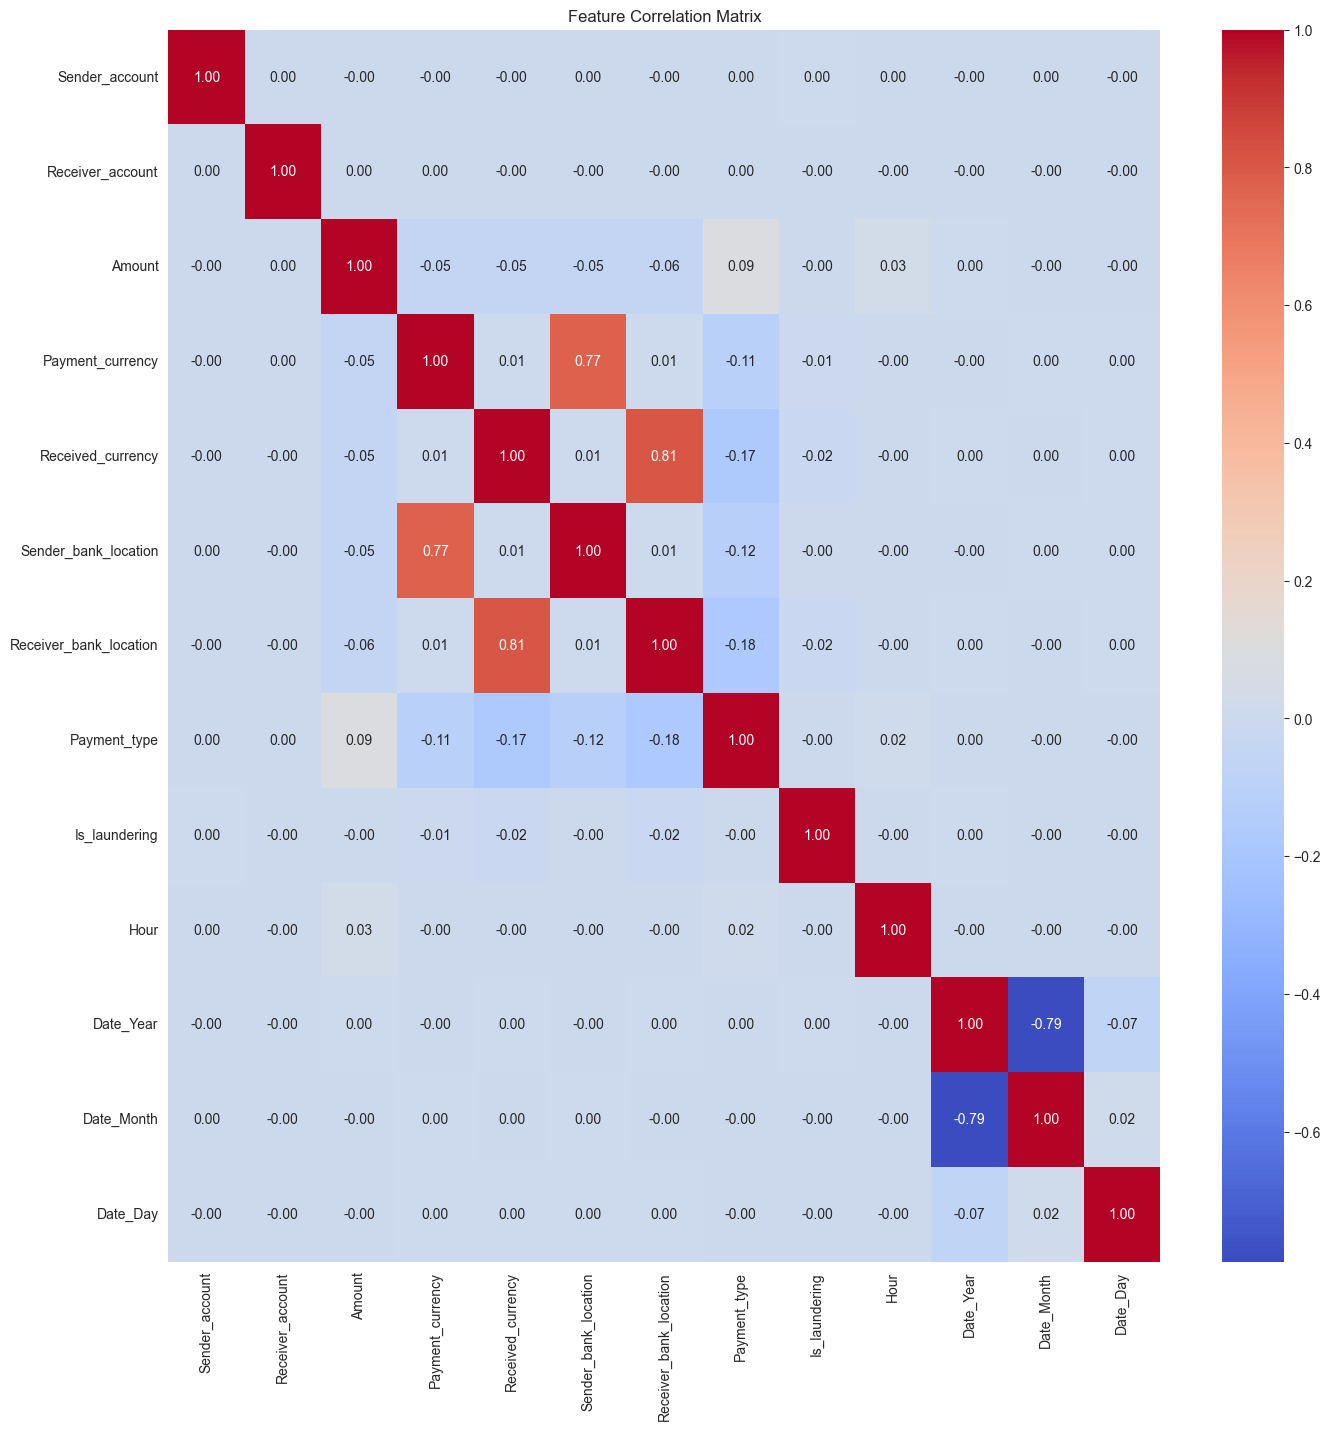

In [28]:
correlation_matrix = df.corr()

plt.figure(figsize=(16, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Feature Correlation Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.show()

## Split the Data

In [29]:
X = df.drop(columns=['Is_laundering'])
y = df['Is_laundering']

In [30]:
total_size = len(df)
train_size = int(0.8 * total_size)
test_and_validation_size = total_size - train_size
test_size = int(0.5 * test_and_validation_size)
validation_size = test_and_validation_size - test_size

X_train = X[:train_size]
y_train = y[:train_size]

X_validation = X[train_size:train_size+test_size]
y_validation = y[train_size:train_size+test_size]

X_test = X[train_size+test_size:]
y_test = y[train_size+test_size:]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_validation.shape, y_validation.shape)


(7603881, 12) (7603881,) (950486, 12) (950486,) (950485, 12) (950485,)


## XGB Classifier Experiment

In [34]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
     'max_depth': [4,8,16,32],
     'eta': [0.1,0.2,0.3,0.4],
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=2,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best Parameters: ", grid_search.best_params_)

best_model = grid_search.best_estimator_

val_predictions = best_model.predict_proba(X_validation)[:, 1]
val_auc = roc_auc_score(y_validation, val_predictions)
print("Validation AUC: ", val_auc)

test_predictions = best_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_predictions)
print("Test AUC: ", test_auc)

Fitting 2 folds for each of 16 candidates, totalling 32 fits


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...............................eta=0.1, max_depth=4; total time=  18.2s


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...............................eta=0.1, max_depth=4; total time=  18.4s


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...............................eta=0.1, max_depth=8; total time=  26.3s


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...............................eta=0.1, max_depth=8; total time=  28.1s


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..............................eta=0.1, max_depth=16; total time=  50.9s


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:43:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..............................eta=0.1, max_depth=16; total time= 1.0min


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..............................eta=0.1, max_depth=32; total time= 1.0min


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:45:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..............................eta=0.1, max_depth=32; total time=  54.5s


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:46:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...............................eta=0.2, max_depth=4; total time=  22.5s


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:47:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...............................eta=0.2, max_depth=4; total time=  24.3s


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:47:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...............................eta=0.2, max_depth=8; total time=  42.5s


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:48:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...............................eta=0.2, max_depth=8; total time=  30.6s


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:48:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..............................eta=0.2, max_depth=16; total time=  40.9s


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:49:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..............................eta=0.2, max_depth=16; total time=  59.5s


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:50:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..............................eta=0.2, max_depth=32; total time= 2.0min


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:52:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..............................eta=0.2, max_depth=32; total time= 1.3min


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:53:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...............................eta=0.3, max_depth=4; total time=  21.5s


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:54:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...............................eta=0.3, max_depth=4; total time=  24.5s


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:54:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...............................eta=0.3, max_depth=8; total time=  38.6s


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:55:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...............................eta=0.3, max_depth=8; total time=  36.4s


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:55:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..............................eta=0.3, max_depth=16; total time=  41.6s


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:56:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..............................eta=0.3, max_depth=16; total time=  43.6s


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:57:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..............................eta=0.3, max_depth=32; total time= 2.0min


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:59:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..............................eta=0.3, max_depth=32; total time= 1.5min


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:00:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...............................eta=0.4, max_depth=4; total time=  29.3s


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:01:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...............................eta=0.4, max_depth=4; total time=  30.8s


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:01:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...............................eta=0.4, max_depth=8; total time=  52.6s


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:02:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...............................eta=0.4, max_depth=8; total time=  40.4s


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:03:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..............................eta=0.4, max_depth=16; total time=  44.2s


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:04:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..............................eta=0.4, max_depth=16; total time=  50.5s


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:04:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..............................eta=0.4, max_depth=32; total time= 1.6min


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:06:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..............................eta=0.4, max_depth=32; total time= 1.1min


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:07:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters:  {'eta': 0.1, 'max_depth': 4}
Validation AUC:  0.8163723163977984
Test AUC:  0.8113567983781008


Test Set AUC:  0.8113567983781008


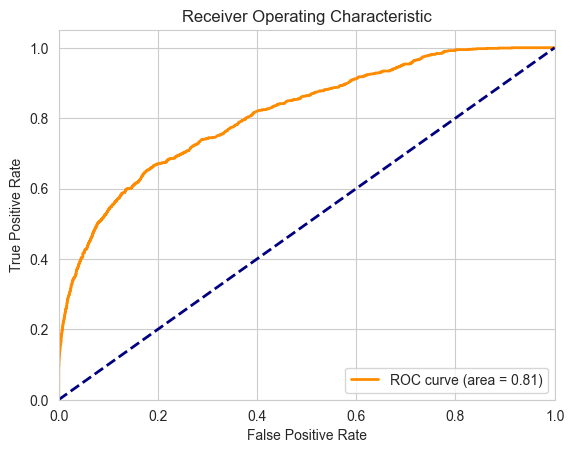

In [38]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

test_probabilities = best_model.predict_proba(X_test)[:, 1]

test_auc = roc_auc_score(y_test, test_probabilities)
print("Test Set AUC: ", test_auc)

fpr, tpr, thresholds = roc_curve(y_test, test_probabilities)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % test_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Desired TPR of around 90%:


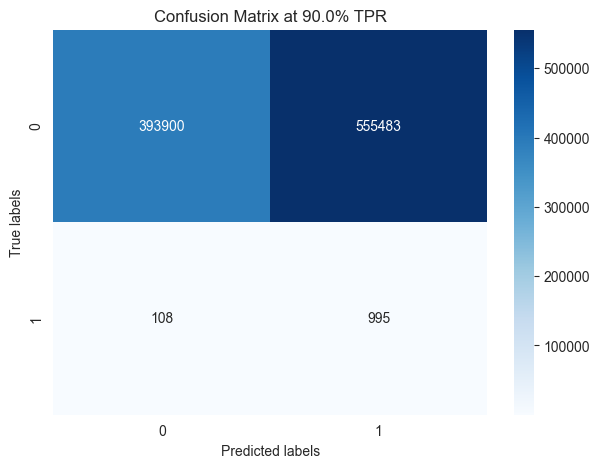

False Positive Rate (FPR): 0.585
True Positive Rate (TPR): 0.902


In [40]:
# Confusion Matrix, TPR, and FPR at around a TPR of 0.9
desired_tpr = 0.9
closest_threshold = thresholds[np.argmin(np.abs(tpr - desired_tpr))]
print(f"Desired TPR of around 90%:")

y_pred = (test_probabilities >= closest_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Confusion Matrix at {desired_tpr*100}% TPR')
plt.show()

tn, fp, fn, tp = cm.ravel()
fpr_cm = fp / (fp + tn)
tpr_cm = tp / (tp + fn)

print(f"False Positive Rate (FPR): {fpr_cm:.3f}")
print(f"True Positive Rate (TPR): {tpr_cm:.3f}")

In [36]:
import xgboost as xgb
from tensorflow.keras.models import save_model

# Assuming your XGBoost model is already trained

# Save to HDF5 (.h5) format
best_model.save_model("xgboost_model.h5")
print("XGBoost model saved as .h5")


XGBoost model saved as .h5


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:25:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
